In [1]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv, GraphConv, TransformerConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.nn import BatchNorm, LayerNorm
import math
from torch_geometric.data import Data, DataLoader
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.explain import Explainer, GNNExplainer

c:\Users\LENOVO\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adj = pd.read_excel('adjacency_geografi.xlsx', index_col=0)
province_order = adj.columns.tolist()
for i, province in enumerate(province_order):
    province_order[i] = province.upper()

print(province_order)

['SULAWESI TENGAH', 'SULAWESI BARAT', 'SULAWESI SELATAN', 'PAPUA BARAT', 'GORONTALO', 'RIAU', 'DAERAH ISTIMEWA YOGYAKARTA', 'SUMATERA BARAT', 'DKI JAKARTA', 'MALUKU', 'BENGKULU', 'LAMPUNG', 'PAPUA', 'KEPULAUAN RIAU', 'NUSA TENGGARA BARAT', 'JAMBI', 'BALI', 'JAWA TIMUR', 'SUMATERA UTARA', 'SULAWESI TENGGARA', 'NUSA TENGGARA TIMUR', 'KALIMANTAN SELATAN', 'ACEH', 'KALIMANTAN TENGAH', 'KEPULAUAN BANGKA BELITUNG', 'SUMATERA SELATAN', 'BANTEN', 'SULAWESI UTARA', 'KALIMANTAN UTARA', 'KALIMANTAN TIMUR', 'JAWA TENGAH', 'MALUKU UTARA', 'KALIMANTAN BARAT', 'JAWA BARAT']


In [3]:
df = pd.read_excel('Sorted.xlsx')

years = df['Tahun'].unique()

similarity_matrices = {}

for year in years:
    df_year = df[df['Tahun'] == year].copy()

    df_year.set_index('Provinsi', inplace=True)

    input_feature = df_year.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Tahun', 'Stunting'])

    scaler = MinMaxScaler()

    feature_scaled = scaler.fit_transform(input_feature)

    similarity_matrix = cosine_similarity(feature_scaled)

    similarity_df = pd.DataFrame(similarity_matrix,
                                 index=input_feature.index,
                                 columns=input_feature.index)
    
    similarity_matrices[year] = similarity_df

    similarity_df.to_excel(f"Graf 2018-2023/Similarity_Matrix_for_{year}.xlsx")

In [4]:


def get_edge_index_from_similarity(sim_matrix, threshold=0.85):
    edges = []
    n = sim_matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i != j and sim_matrix[i, j] >= threshold:
                edges.append([i, j])
    return torch.tensor(edges).t().contiguous()  # shape [2, num_edges]


In [5]:
adj = pd.read_excel('adjacency_geografi.xlsx', index_col=0)

# Buat mapping provinsi
province_list = adj.columns.tolist()
province_to_idx = {prov.upper(): idx for idx, prov in enumerate(province_list)}

# Buat edge_index
edge_index = []

for i, source in enumerate(province_list):
    for j, target in enumerate(province_list):
        if adj.iloc[i, j] == 1:
            edge_index.append([i, j])  # <--- harus pakai i, j dari enumerate (bukan nilai dari file langsung)

edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, num_edges]

In [6]:
graphs_spatial = []
graphs_similarity = []

for tahun in years:
    # ambil fitur dan target provinsi di tahun ini
    fitur_tahun = df[df['Tahun'] == tahun].drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'Tahun', 'Stunting'])
    target_tahun = df[df['Tahun'] == tahun]['Stunting']
    sim_matrix = similarity_matrices[tahun].values # N x N matrix
    
    x = torch.tensor(fitur_tahun.values, dtype=torch.float)
    y = torch.tensor(target_tahun.values, dtype=torch.float)
    
    # adjacency edge index (tetap)
    edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
    
    # similarity edge index (dinamis)
    edge_index_sim = get_edge_index_from_similarity(sim_matrix, threshold=0.85)

    # buat 2 graph data terpisah
    data_spatial = Data(x=x, edge_index=edge_index_spatial)
    data_similarity = Data(x=x, edge_index=edge_index_sim)

    # simpan
    graphs_spatial.append(data_spatial)
    graphs_similarity.append(data_similarity)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13896\538702535.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13896\538702535.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13896\538702535.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch

In [7]:
print(f'Graph Spacial: {graphs_spatial}')

print(f'Graph Similarity: {graphs_similarity}')

Graph Spacial: [Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62])]
Graph Similarity: [Data(x=[34, 8], edge_index=[2, 906]), Data(x=[34, 8], edge_index=[2, 906]), Data(x=[34, 8], edge_index=[2, 904]), Data(x=[34, 8], edge_index=[2, 968]), Data(x=[34, 8], edge_index=[2, 938]), Data(x=[34, 8], edge_index=[2, 958])]


In [8]:
for year, (g1, g2) in enumerate(zip(graphs_spatial, graphs_similarity)):
    print(f"Tahun {year + 2018}")
    print("Spatial edge max:", g1.edge_index.max().item())
    print("Similarity edge max:", g2.edge_index.max().item())

Tahun 2018
Spatial edge max: 33
Similarity edge max: 33
Tahun 2019
Spatial edge max: 33
Similarity edge max: 33
Tahun 2020
Spatial edge max: 33
Similarity edge max: 33
Tahun 2021
Spatial edge max: 33
Similarity edge max: 33
Tahun 2022
Spatial edge max: 33
Similarity edge max: 33
Tahun 2023
Spatial edge max: 33
Similarity edge max: 33


In [9]:
# class DualBranchGNN(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super().__init__()
        
#         # Branch 1: Spatial Graph
#         self.conv_spatial_1 = SAGEConv(in_channels, hidden_channels)
#         self.norm_spatial_1 = torch.nn.LayerNorm(hidden_channels)
        
#         self.conv_spatial_2 = SAGEConv(hidden_channels, hidden_channels)
#         self.norm_spatial_2 = torch.nn.LayerNorm(hidden_channels)
        
#         # Branch 2: Similarity Graph
#         self.conv_sim_1 = SAGEConv(in_channels, hidden_channels)
#         self.norm_sim_1 = torch.nn.LayerNorm(hidden_channels)
        
#         self.conv_sim_2 = SAGEConv(hidden_channels, hidden_channels)
#         self.norm_sim_2 = torch.nn.LayerNorm(hidden_channels)
        
#         # Output layer
#         self.out_layer = torch.nn.Linear(hidden_channels * 2, out_channels)

#     def forward(self, data_spatial, data_sim):
#         # Spatial branch
#         x1 = self.conv_spatial_1(data_spatial.x, data_spatial.edge_index)
#         x1 = self.norm_spatial_1(x1)
#         x1 = F.relu(x1)
        
#         x1 = self.conv_spatial_2(x1, data_spatial.edge_index)
#         x1 = self.norm_spatial_2(x1)
#         x1 = F.relu(x1)
        
#         # Similarity branch
#         x2 = self.conv_sim_1(data_sim.x, data_sim.edge_index)
#         x2 = self.norm_sim_1(x2)
#         x2 = F.relu(x2)
        
#         x2 = self.conv_sim_2(x2, data_sim.edge_index)
#         x2 = self.norm_sim_2(x2)
#         x2 = F.relu(x2)
        
#         # Concatenate
#         x = torch.cat([x1, x2], dim=1)
#         out = self.out_layer(x)
#         return out

#     def get_embedding(self, data_spatial, data_sim):
#         # Spatial branch
#         x1 = self.conv_spatial_1(data_spatial.x, data_spatial.edge_index)
#         x1 = self.norm_spatial_1(x1)
#         x1 = F.relu(x1)
        
#         x1 = self.conv_spatial_2(x1, data_spatial.edge_index)
#         x1 = self.norm_spatial_2(x1)
#         x1 = F.relu(x1)
        
#         # Similarity branch
#         x2 = self.conv_sim_1(data_sim.x, data_sim.edge_index)
#         x2 = self.norm_sim_1(x2)
#         x2 = F.relu(x2)
        
#         x2 = self.conv_sim_2(x2, data_sim.edge_index)
#         x2 = self.norm_sim_2(x2)
#         x2 = F.relu(x2)
        
#         # Concatenate tanpa output layer
#         x = torch.cat([x1, x2], dim=1)  # Ini hasil embedding gabungan
#         return x




In [10]:
# model = DualBranchGNN(in_channels=8, hidden_channels=256, out_channels=1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# loss_fn = torch.nn.MSELoss()

# best_loss = float('inf')
# best_model_state = None

# for epoch in range(1000):
#     model.train()
#     total_loss = 0

#     for year in range(6):  # 6 tahun
#         data_spatial = graphs_spatial[year]
#         data_sim = graphs_similarity[year]
#         y_true = data_spatial.y.view(-1, 1)  # Target
        
#         optimizer.zero_grad()
#         out = model(data_spatial, data_sim)
#         loss = loss_fn(out, y_true)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()

#     # Simpan model jika loss lebih baik
#     if total_loss < best_loss:
#         best_loss = total_loss
#         best_model_state = model.state_dict()  # Save best weights

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch} - Loss: {total_loss:.4f} {'(BEST)' if total_loss == best_loss else ''}")



In [11]:
# model.load_state_dict(best_model_state)
# model.eval()
# all_preds = []
# all_targets = []
# gnn_embeddings_all = []

# with torch.no_grad():
#     for spatial_data, sim_data in zip(graphs_spatial, graphs_similarity):
#         # Kirim kedua data ke model
#         out = model(spatial_data, sim_data)

#         embedding = model.get_embedding(spatial_data, sim_data)
#         gnn_embeddings_all.append(embedding)

#         y_pred = out.squeeze().cpu().numpy()
#         y_true = spatial_data.y.squeeze().cpu().numpy()  # atau sim_data.y, sama saja

#         all_preds.extend(y_pred)
#         all_targets.extend(y_true)


# gnn_embeddings_all = torch.cat(gnn_embeddings_all, dim=0)  # [204, hidden_dim*2]
# print(gnn_embeddings_all.shape)

# for true, pred in zip(all_targets, all_preds):
#     print(f'True Value: {round(float(true), 2)}, Predicted: {round(float(pred), 2)}')

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x







In [13]:
from torch_geometric.nn.models import DeepGraphInfomax

def corruption(x, edge_index):
    # Shuffle fitur node (negatif sampel)
    return x[torch.randperm(x.size(0))], edge_index

def create_dgi_model(in_channels, hidden_channels):
    encoder = GCNEncoder(in_channels, hidden_channels)
    dgi = DeepGraphInfomax(
        hidden_channels=hidden_channels,
        encoder=encoder,
        summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
        corruption=corruption
    )
    return dgi


In [14]:
def train_dgi(dgi, data, epochs=100, lr=0.001):
    optimizer = torch.optim.AdamW(dgi.parameters(), lr=lr)
    dgi.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        pos_z, neg_z, summary = dgi(data.x, data.edge_index)
        loss = dgi.loss(pos_z, neg_z, summary)
        loss.backward()
        optimizer.step()
    dgi.eval()
    with torch.no_grad():
        z, _, _ = dgi(data.x, data.edge_index)
    return z  # [34, hidden_dim]


In [15]:
all_embeddings = []

for tahun in range(len(graphs_spatial)):
    print(f"Tahun {tahun}")
    
    # Spatial Graph
    dgi_spatial = create_dgi_model(in_channels=8, hidden_channels=32)
    emb_spatial = train_dgi(dgi_spatial, graphs_spatial[tahun])
    
    # Similarity Graph
    dgi_sim = create_dgi_model(in_channels=8, hidden_channels=32)
    emb_sim = train_dgi(dgi_sim, graphs_similarity[tahun])
    
    # Concatenate [34, 32]
    emb_combined = torch.cat([emb_spatial, emb_sim], dim=1)
    
    # Tambahkan ke list
    all_embeddings.append(emb_combined)


Tahun 0
Tahun 1
Tahun 2
Tahun 3
Tahun 4
Tahun 5


In [16]:
nama_fitur = fitur_tahun.columns
print(nama_fitur)

Index(['SD / Sederajat', 'SMP / Sederajat', 'SMA / Sederajat',
       'Prevalensi Ketidakcukupan Konsumsi Pangan (Persen)',
       'Konsumsi Kalori Per Hari Per Kapita',
       'Konsumsi Protein Per Hari Per Kapita', 'Kemisikinan Maret',
       'Akses Sanitasi Bersih'],
      dtype='object')


# Using GNN Embedding

In [17]:
from tabpfn import TabPFNRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.decomposition import PCA

# Load dan preprocessing
df = pd.read_excel('Sorted.xlsx')
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'SMP / Sederajat', 'SMA / Sederajat'])

X = df.drop(columns='Stunting')
y = df['Stunting']


print(np.array(all_embeddings).shape)
x_gnn = np.array(all_embeddings).reshape(-1, 64)
print(np.array(x_gnn).shape)


scaler = MinMaxScaler()

X_combined = np.concatenate([x_gnn, X], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(6, 34, 64)
(204, 64)


In [18]:
from pytorch_tabnet.tab_model import TabNetRegressor
reg = TabNetRegressor(
    n_d=24,
    n_a=24,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-3,
    momentum=0.3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01, weight_decay=1e-5),
    mask_type='entmax',        # 'sparsemax' or 'entmax'
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="min", patience=10, factor=0.7),
    seed=42,
    verbose=1
)

reg.fit(
    X_train, np.array(y_train).reshape(-1, 1),
    max_epochs=200,
    patience=30,               # Early stopping patience
    batch_size=512,
    virtual_batch_size=128,    # For ghost batch normalization
    num_workers=0,
    drop_last=False,
    loss_fn=None               # Uses MSE by default for regression
)


c:\Users\LENOVO\miniconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\LENOVO\miniconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 661.92584|  0:00:00s
epoch 1  | loss: 633.19495|  0:00:00s
epoch 2  | loss: 609.70422|  0:00:00s
epoch 3  | loss: 585.73676|  0:00:00s
epoch 4  | loss: 557.09418|  0:00:00s
epoch 5  | loss: 529.29987|  0:00:00s
epoch 6  | loss: 502.0946|  0:00:01s
epoch 7  | loss: 478.63159|  0:00:01s
epoch 8  | loss: 450.78415|  0:00:01s
epoch 9  | loss: 428.03104|  0:00:01s
epoch 10 | loss: 406.88217|  0:00:01s
epoch 11 | loss: 379.89865|  0:00:01s
epoch 12 | loss: 356.5867|  0:00:01s
epoch 13 | loss: 334.9939|  0:00:01s
epoch 14 | loss: 312.55005|  0:00:01s
epoch 15 | loss: 293.20013|  0:00:01s
epoch 16 | loss: 270.79349|  0:00:01s
epoch 17 | loss: 250.2471|  0:00:01s
epoch 18 | loss: 230.97293|  0:00:01s
epoch 19 | loss: 211.08253|  0:00:01s
epoch 20 | loss: 191.74451|  0:00:01s
epoch 21 | loss: 174.53578|  0:00:01s
epoch 22 | loss: 163.51884|  0:00:01s
epoch 23 | loss: 139.96957|  0:00:01s
epoch 24 | loss: 125.72983|  0:00:01s
epoch 25 | loss: 110.99335|  0:00:01s
epoch 26 | loss:

In [19]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(
    iterations=865,
    depth=8,
    learning_rate=0.06776272583857657,
    l2_leaf_reg=2.957811554875259,
    random_strength=1.006841070057302,
    bagging_temperature=0.2530268852604008,
    loss_function='RMSE',   # WAJIB karena ini regression
    verbose=1               # biar tidak terlalu banyak output saat training
)

cat.fit(X_train, y_train)

0:	learn: 6.6444484	total: 165ms	remaining: 2m 22s
1:	learn: 6.4892180	total: 176ms	remaining: 1m 15s
2:	learn: 6.3220625	total: 186ms	remaining: 53.5s
3:	learn: 6.1614769	total: 189ms	remaining: 40.8s
4:	learn: 6.0462261	total: 201ms	remaining: 34.5s
5:	learn: 5.8981404	total: 212ms	remaining: 30.3s
6:	learn: 5.7929565	total: 222ms	remaining: 27.3s
7:	learn: 5.6755827	total: 232ms	remaining: 24.9s
8:	learn: 5.5835595	total: 243ms	remaining: 23.2s
9:	learn: 5.4737480	total: 257ms	remaining: 21.9s
10:	learn: 5.3756477	total: 266ms	remaining: 20.6s
11:	learn: 5.2784639	total: 275ms	remaining: 19.5s
12:	learn: 5.1912595	total: 283ms	remaining: 18.6s
13:	learn: 5.1146829	total: 292ms	remaining: 17.7s
14:	learn: 5.0238744	total: 300ms	remaining: 17s
15:	learn: 4.9703284	total: 303ms	remaining: 16.1s
16:	learn: 4.8883522	total: 313ms	remaining: 15.6s
17:	learn: 4.8179959	total: 322ms	remaining: 15.1s
18:	learn: 4.7583538	total: 330ms	remaining: 14.7s
19:	learn: 4.6879193	total: 339ms	remaini

In [20]:
tabfpn = TabPFNRegressor(device='cuda' if torch.cuda.is_available() else 'cpu', ignore_pretraining_limits=True)
tabfpn.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [21]:
y_pred = cat.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 17.849570698147463
MAE: 3.2297668475687322
R2 Score: 0.5939169385223233


In [22]:
y_pred = reg.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 30.83193267353522
MAE: 4.362710728529023
R2 Score: 0.29856432834867963


In [23]:
y_pred = tabfpn.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 9.667143115483976
MAE: 2.3299134705706335
R2 Score: 0.7800696084816198


In [24]:
y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 17.768573886646553
MAE: 3.3618524390244073
R2 Score: 0.595759640161508


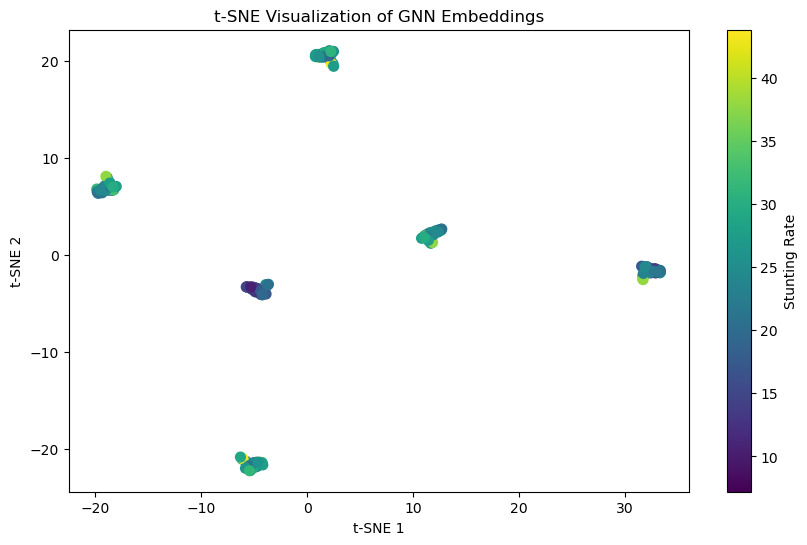

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Misal X adalah embedding dari GNN (204, 512)
X = x_gnn

# Jalankan t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualisasi
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50)
plt.title("t-SNE Visualization of GNN Embeddings")
plt.colorbar(label='Stunting Rate')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


# Without GNN Embedding

In [26]:
df = pd.read_excel('Sorted.xlsx')
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'SMP / Sederajat', 'SMA / Sederajat'])

X = df.drop(columns='Stunting')
y = df['Stunting']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
reg = TabNetRegressor(
    n_d=24,
    n_a=24,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-3,
    momentum=0.3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01, weight_decay=1e-5),
    mask_type='entmax',        # 'sparsemax' or 'entmax'
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="min", patience=10, factor=0.7),
    seed=42,
    verbose=1
)

cat = CatBoostRegressor(
    iterations=865,
    depth=8,
    learning_rate=0.06776272583857657,
    l2_leaf_reg=2.957811554875259,
    random_strength=1.006841070057302,
    bagging_temperature=0.2530268852604008,
    loss_function='RMSE',   # WAJIB karena ini regression
    verbose=1               # biar tidak terlalu banyak output saat training
)

tabfpn = TabPFNRegressor(device='cuda' if torch.cuda.is_available() else 'cpu', ignore_pretraining_limits=True)

rf = RandomForestRegressor(n_estimators=1000)

c:\Users\LENOVO\miniconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [28]:
cat.fit(X_train, y_train)
reg.fit(
    X_train, np.array(y_train).reshape(-1, 1),
    max_epochs=200,
    patience=30,               # Early stopping patience
    batch_size=512,
    virtual_batch_size=128,    # For ghost batch normalization
    num_workers=0,
    drop_last=False,
    loss_fn=None               # Uses MSE by default for regression
)
tabfpn.fit(X_train, y_train)
rf.fit(X_train, y_train)

0:	learn: 6.6400236	total: 2.62ms	remaining: 2.26s
1:	learn: 6.4676273	total: 3.35ms	remaining: 1.45s
2:	learn: 6.3064036	total: 5.22ms	remaining: 1.5s
3:	learn: 6.1588475	total: 8.21ms	remaining: 1.77s
4:	learn: 6.0075861	total: 10ms	remaining: 1.72s
5:	learn: 5.8560959	total: 12.4ms	remaining: 1.78s
6:	learn: 5.7268235	total: 14.9ms	remaining: 1.83s
7:	learn: 5.6038063	total: 17.1ms	remaining: 1.83s
8:	learn: 5.4913719	total: 17.5ms	remaining: 1.66s
9:	learn: 5.3861156	total: 19.8ms	remaining: 1.69s
10:	learn: 5.2704660	total: 22ms	remaining: 1.7s
11:	learn: 5.1798125	total: 23.9ms	remaining: 1.7s
12:	learn: 5.0956961	total: 25.9ms	remaining: 1.7s
13:	learn: 4.9959077	total: 28.1ms	remaining: 1.71s
14:	learn: 4.8856440	total: 30ms	remaining: 1.7s
15:	learn: 4.7898461	total: 32ms	remaining: 1.7s
16:	learn: 4.6986186	total: 34ms	remaining: 1.7s
17:	learn: 4.6141082	total: 35.9ms	remaining: 1.69s
18:	learn: 4.5393999	total: 36.6ms	remaining: 1.63s
19:	learn: 4.4474961	total: 38.4ms	rema

c:\Users\LENOVO\miniconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 4  | loss: 438.89706|  0:00:00s
epoch 5  | loss: 415.41199|  0:00:00s
epoch 6  | loss: 375.07974|  0:00:00s
epoch 7  | loss: 351.75064|  0:00:00s
epoch 8  | loss: 321.42645|  0:00:00s
epoch 9  | loss: 296.42719|  0:00:00s
epoch 10 | loss: 269.81573|  0:00:00s
epoch 11 | loss: 249.5107|  0:00:00s
epoch 12 | loss: 227.55011|  0:00:00s
epoch 13 | loss: 208.40321|  0:00:00s
epoch 14 | loss: 186.86494|  0:00:00s
epoch 15 | loss: 162.7077|  0:00:00s
epoch 16 | loss: 144.05386|  0:00:00s
epoch 17 | loss: 132.41489|  0:00:00s
epoch 18 | loss: 108.33552|  0:00:00s
epoch 19 | loss: 96.7469 |  0:00:00s
epoch 20 | loss: 85.95209|  0:00:00s
epoch 21 | loss: 73.56398|  0:00:00s
epoch 22 | loss: 62.52303|  0:00:00s
epoch 23 | loss: 54.23654|  0:00:00s
epoch 24 | loss: 43.13838|  0:00:00s
epoch 25 | loss: 36.96067|  0:00:00s
epoch 26 | loss: 34.00666|  0:00:00s
epoch 27 | loss: 33.3217 |  0:00:00s
epoch 28 | loss: 29.80103|  0:00:00s
epoch 29 | loss: 27.95169|  0:00:00s
epoch 30 | loss: 33.20176

c:\Users\LENOVO\miniconda3\Lib\site-packages\torch\utils\data\_utils\collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


RandomForestRegressor(n_estimators=1000)

In [29]:
y_pred = cat.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 13.061392758323251
MAE: 2.7433729494779855
R2 Score: 0.7028494159238943


In [30]:
y_pred = reg.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 54.64850419803657
MAE: 5.622384745900224
R2 Score: -0.2432697830776156


In [31]:
y_pred = tabfpn.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 11.088701653636994
MAE: 2.5889280700683592
R2 Score: 0.7477287274035768


In [32]:
y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 12.74676619964629
MAE: 2.6744202439024427
R2 Score: 0.710007264049787


In [33]:
# Load dan preprocessing

print(np.array(all_embeddings).shape)
x_gnn = np.array(all_embeddings).reshape(-1, 64)
print(np.array(x_gnn).shape)


scaler = MinMaxScaler()


X_train, X_test, y_train, y_test = train_test_split(
    x_gnn, y, test_size=0.2, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(6, 34, 64)
(204, 64)


In [34]:
reg = TabNetRegressor(
    n_d=24,
    n_a=24,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-3,
    momentum=0.3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01, weight_decay=1e-5),
    mask_type='entmax',        # 'sparsemax' or 'entmax'
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="min", patience=10, factor=0.7),
    seed=42,
    verbose=1
)

cat = CatBoostRegressor(
    iterations=865,
    depth=8,
    learning_rate=0.06776272583857657,
    l2_leaf_reg=2.957811554875259,
    random_strength=1.006841070057302,
    bagging_temperature=0.2530268852604008,
    loss_function='RMSE',   # WAJIB karena ini regression
    verbose=1               # biar tidak terlalu banyak output saat training
)

tabfpn = TabPFNRegressor(device='cuda' if torch.cuda.is_available() else 'cpu', ignore_pretraining_limits=True)

rf = RandomForestRegressor(n_estimators=1000)

c:\Users\LENOVO\miniconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [36]:
cat.fit(X_train, y_train)
tabfpn.fit(X_train, y_train)
rf.fit(X_train, y_train)

0:	learn: 6.6583833	total: 21.7ms	remaining: 18.8s
1:	learn: 6.5390923	total: 27.1ms	remaining: 11.7s
2:	learn: 6.4135670	total: 40ms	remaining: 11.5s
3:	learn: 6.3168126	total: 51.4ms	remaining: 11.1s
4:	learn: 6.1986967	total: 60.2ms	remaining: 10.4s
5:	learn: 6.1096634	total: 67.4ms	remaining: 9.65s
6:	learn: 6.0221626	total: 75.9ms	remaining: 9.3s
7:	learn: 5.9464451	total: 83.3ms	remaining: 8.92s
8:	learn: 5.8607469	total: 91.6ms	remaining: 8.71s
9:	learn: 5.7958643	total: 102ms	remaining: 8.75s
10:	learn: 5.7303492	total: 110ms	remaining: 8.52s
11:	learn: 5.6716090	total: 117ms	remaining: 8.31s
12:	learn: 5.5938090	total: 121ms	remaining: 7.93s
13:	learn: 5.5375876	total: 128ms	remaining: 7.77s
14:	learn: 5.4817210	total: 135ms	remaining: 7.64s
15:	learn: 5.4271395	total: 139ms	remaining: 7.36s
16:	learn: 5.3743752	total: 146ms	remaining: 7.26s
17:	learn: 5.3233232	total: 153ms	remaining: 7.2s
18:	learn: 5.2788130	total: 160ms	remaining: 7.12s
19:	learn: 5.2437999	total: 167ms	re

RandomForestRegressor(n_estimators=1000)

In [37]:
y_pred = cat.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 36.155745948048235
MAE: 5.010773893370816
R2 Score: 0.17744598719585203


In [38]:
y_pred = tabfpn.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 31.004712089953472
MAE: 4.090689075749094
R2 Score: 0.2946335450505283


In [39]:
y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 32.34357724587451
MAE: 4.554216277584227
R2 Score: 0.26417396310222796
